In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from datetime import datetime

%matplotlib inline

# GitHub Users Analysis

In [55]:
categories = {
    'watch': ['WatchEvent', 'ForkEvent'],
    'interact': ['CommitCommentEvent', 'GollumEvent', 'PullRequestReviewCommentEvent','IssuesEvent', 
                 'IssueCommentEvent'],
    'contribute': ['CreateEvent', 'DeleteEvent', 'PullRequestEvent', 'PushEvent','ReleaseEvent', 'MemberEvent'],
    #'fork': ['ForkEvent']
}

cat_list = ['contribute','interact','watch']
cat_list_2 = cat_list + ['fork']

def define_category(event):
    for c in categories.keys():
        if event in categories[c]:
            return c

def get_perc_distr(row):
    sum_a = sum([row[c] for c in categories.keys()])
    
    norm_row = {}
    for c in categories.keys():
        norm_row[c] = float(row[c])/sum_a
        
    return pd.Series(norm_row)

In [35]:
# https://gist.github.com/diogojc/1394300
def powerLaw(y, x):
    """
    'When the frequency of an event varies as power of some attribute of that
    event the frequency is said to follow a power law.' (wikipedia)
    This is represented by the following equation, where c and alpha are
    constants:
    y = c . x ^ alpha
    Args
    --------
    y: array with frequency of events >0
    x: numpy array with attribute of events >0
    Output
    --------
    (c, alpha)
    c: the maximum frequency of any event
    alpha: defined by (Newman, 2005 for details):
        alpha = 1 + n * sum(ln( xi / xmin )) ^ -1
    """
    c = 0
    alpha = .0

    if len(y) and len(y)==len(x):
        c = max(y)
        xmin = float(min(x))
        alpha = 1 + len(x) * pow(sum(np.log(x/xmin)),-1)

    return (c, alpha)

In [3]:
path = './'

# Users behavior

Analysis of users and how they interact inside target projects based on historical data of GitHub activities in **2015** and **2016**.

In [4]:
# data import
a18 = pd.read_csv(path + 'random_a_2018.csv', parse_dates=['created_at'])

In [5]:
a18.head()

,source,target,event,created_at
0,31112174,116623421,PushEvent,2018-01-09 03:20:29
1,31112174,116623421,PushEvent,2018-01-09 03:27:01
2,22441396,116756658,PushEvent,2018-01-09 03:53:14
3,26319209,101191801,PushEvent,2018-01-23 07:04:50
4,31496399,118575282,CreateEvent,2018-01-23 07:37:58


In [6]:
a18['event'].unique()

array(['PushEvent', 'CreateEvent', 'IssueCommentEvent',
       'PullRequestEvent', 'DeleteEvent', 'WatchEvent', 'GollumEvent',
       'IssuesEvent', 'PullRequestReviewCommentEvent', 'ForkEvent',
       'MemberEvent', 'ReleaseEvent', 'CommitCommentEvent', 'PublicEvent'],
      dtype=object)

In [7]:
# basic statistics
print('#activities: {}'.format(a18.shape[0])) 
print('#users: {}'.format(len(a18['source'].unique())))
print('#projects: {}'.format(len(a18['target'].unique())))

#activities: 24795
#users: 2803
#projects: 500


In [8]:
a_per_p = a18.groupby('target')['source'].count()
a_per_p.describe()

count     500.000000
mean       49.590000
std       428.650174
min         1.000000
25%         2.000000
50%         4.000000
75%        14.000000
max      9213.000000
Name: source, dtype: float64

In [9]:
a_per_p = sorted(a_per_p, reverse=True)

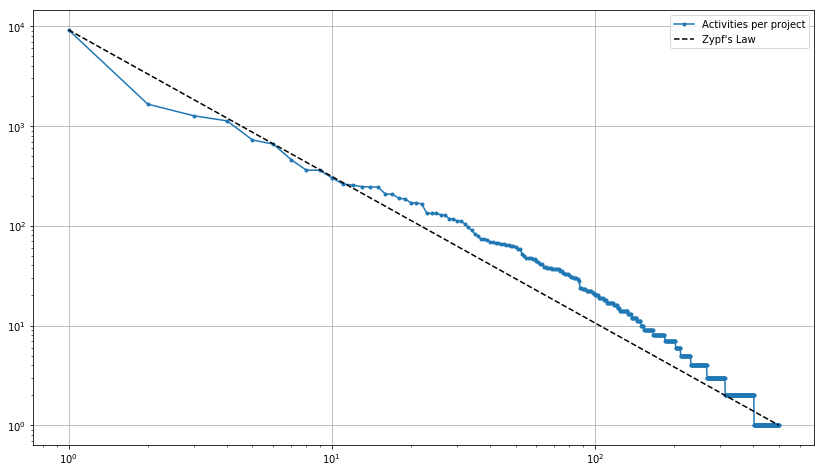

In [10]:
plt.figure(figsize=(14, 8))
x_axis = range(1, len(a_per_p)+1)
plt.loglog(x_axis, a_per_p, marker=".", label='Activities per project')
plt.plot([1, len(a_per_p)],[a_per_p[0] ,a_per_p[-1]], color='k', linestyle='--', label='Zypf\'s Law')
plt.grid()
plt.legend()

In [56]:
a18['cat'] = a18['event'].apply(lambda x: define_category(x))

In [57]:
a18['cat'].value_counts()

contribute    19976
interact       2567
watch          2250
Name: cat, dtype: int64

## Activities Distribution

In [58]:
cat = a18.groupby(by=['target', 'cat'])[['source']].count().reset_index()
cat.columns = ['project', 'category', '#events']

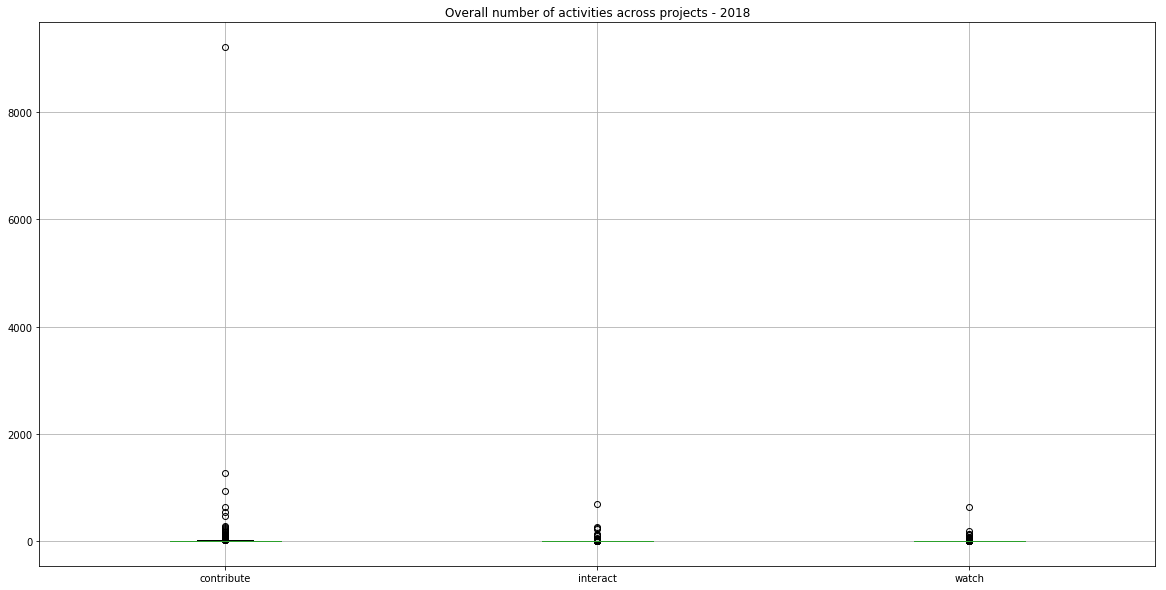

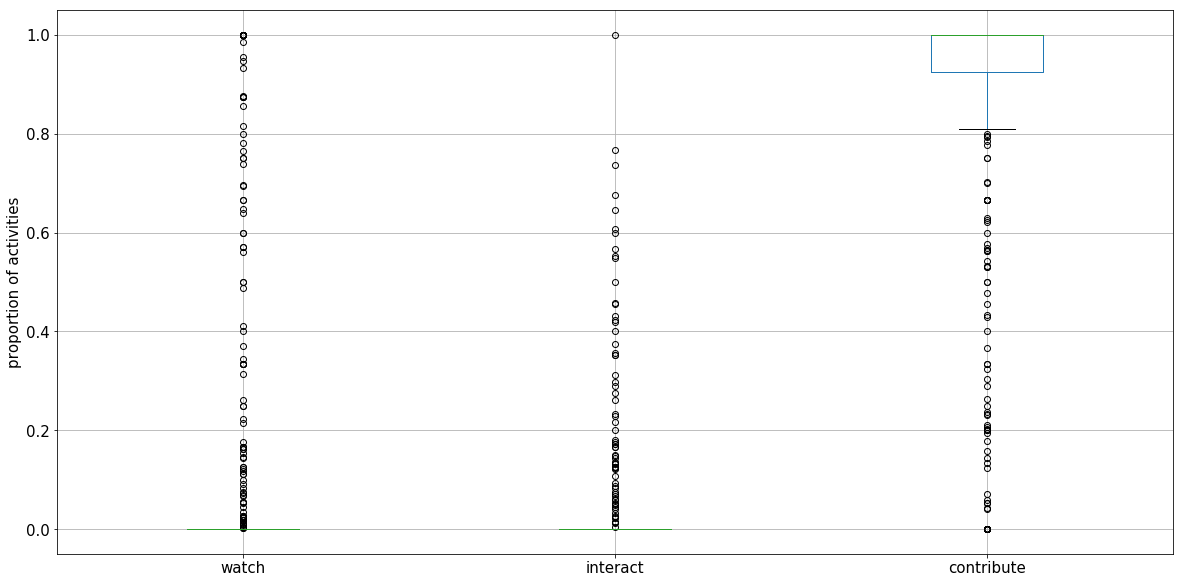

In [59]:
distr = cat.pivot(index='project', columns='category', values='#events').fillna(0)
distr.boxplot(figsize=(20,10))
plt.title('Overall number of activities across projects - 2018')

plt.figure(2, figsize=(20,10))
distr.apply(lambda x: get_perc_distr(x), axis=1).boxplot()
#plt.title('Percentage of activities in each category - 2016')
font = 15
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

In [60]:
distr.apply(lambda x: get_perc_distr(x), axis=1).describe()

,watch,interact,contribute
count,499.000000,499.000000,499.000000
mean,0.129393,0.034322,0.836286
std,0.301175,0.118639,0.328326
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.924039
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [61]:
u_cat = a18.groupby(by=['source', 'cat'])[['target']].count().reset_index()
u_cat.columns = ['user', 'category', '#events']
u_cat.head()

,user,category,#events
0,117,contribute,6
1,2972,watch,1
2,3044,contribute,2
3,3856,watch,2
4,4928,watch,1


In [17]:
r = sorted(u_cat.groupby('user')[['#events']].sum().values, reverse=True)

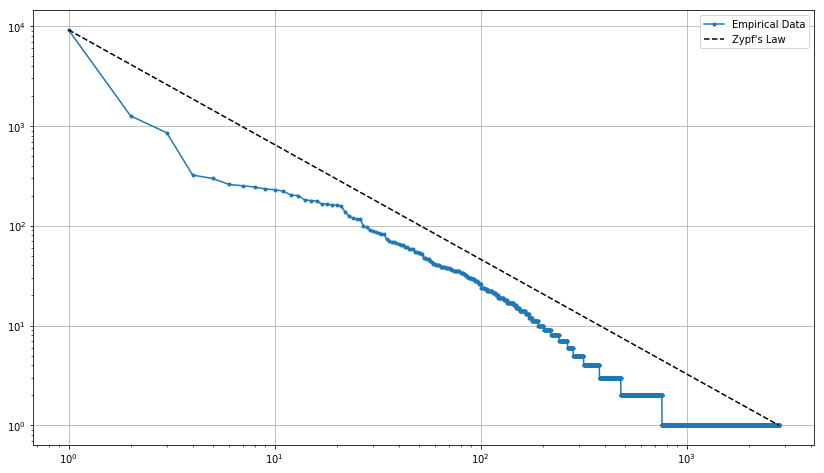

In [18]:
plt.figure(figsize=(14, 8))
x_axis = range(1, len(r)+1)
plt.loglog(x_axis, r, marker=".", label='Empirical Data')
plt.plot([1, len(r)],[r[0] ,1], color='k', linestyle='--', label='Zypf\'s Law')
plt.grid()
plt.legend()

In [74]:
powerLaw(r, np.array(x_axis))

(array([9213]), 1.1440956823070751)

In [65]:
u_distr = u_cat.pivot(index='user', columns='category', values='#events').fillna(0)
u_distr.head()

category,contribute,interact,watch
user,,,
117,6.0,0.0,0.0
2972,0.0,0.0,1.0
3044,2.0,0.0,0.0
3856,0.0,0.0,2.0
4928,0.0,0.0,1.0


In [20]:
u_distr['fork'].unique()

array([0., 1., 2., 3.])

In [21]:
u_distr['watch'].unique()

array([0., 1., 2., 3.])

In [66]:
contribute_rank = u_distr.contribute.sort_values(ascending=False).reset_index(drop=True)
interact_rank = u_distr.interact.sort_values(ascending=False).reset_index(drop=True)
watch_rank = u_distr.watch.sort_values(ascending=False).reset_index(drop=True)
# fork_rank = u_distr.fork.sort_values(ascending=False).reset_index(drop=True)

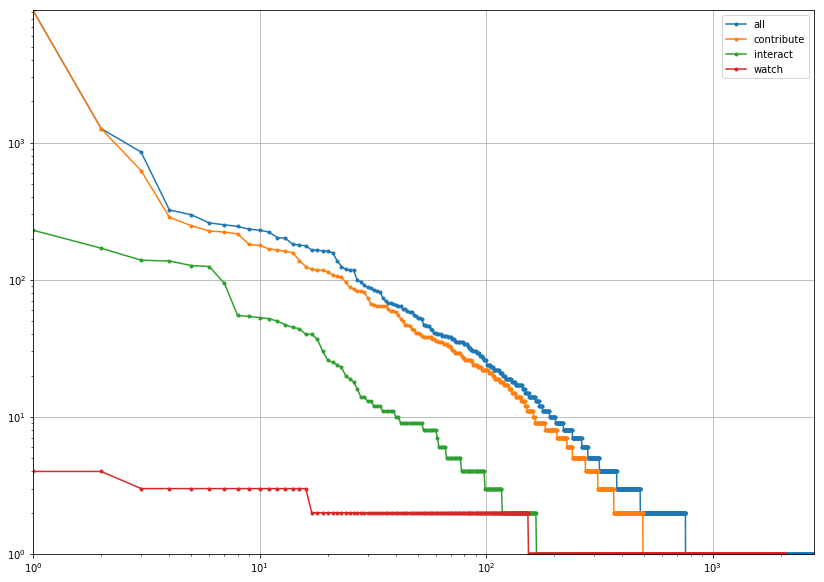

In [67]:
plt.figure(figsize=(14, 10))
x_axis = range(1, len(r)+1)
plt.loglog(x_axis, r, marker=".", label='all')

plt.loglog(x_axis, contribute_rank.values, marker=".", label='contribute')
plt.loglog(x_axis, interact_rank.values, marker=".", label='interact')
plt.loglog(x_axis, watch_rank.values, marker=".", label='watch')
# plt.loglog(x_axis, fork_rank.values, marker=".", label='fork')

#plt.plot([1, len(sample_rank)],[sample_rank.values[0] ,1], color='black', linestyle='--')
plt.xlim([1, len(r)+10])
plt.ylim([1, max(r)+10])
plt.grid()
plt.legend()

In [68]:
norm_u_distr = u_distr.div(u_distr.sum(axis=1), axis=0)
norm_u_distr.head()

category,contribute,interact,watch
user,,,
117,1.0,0.0,0.0
2972,0.0,0.0,1.0
3044,1.0,0.0,0.0
3856,0.0,0.0,1.0
4928,0.0,0.0,1.0


In [49]:
norm_u_distr.shape

(2802, 3)

In [26]:
cmap = cm.get_cmap('OrRd')
colors = []
for i in [0.8, 0.6, 0.4, 0.2]:
    c = cmap(i)
    colors.append(c)

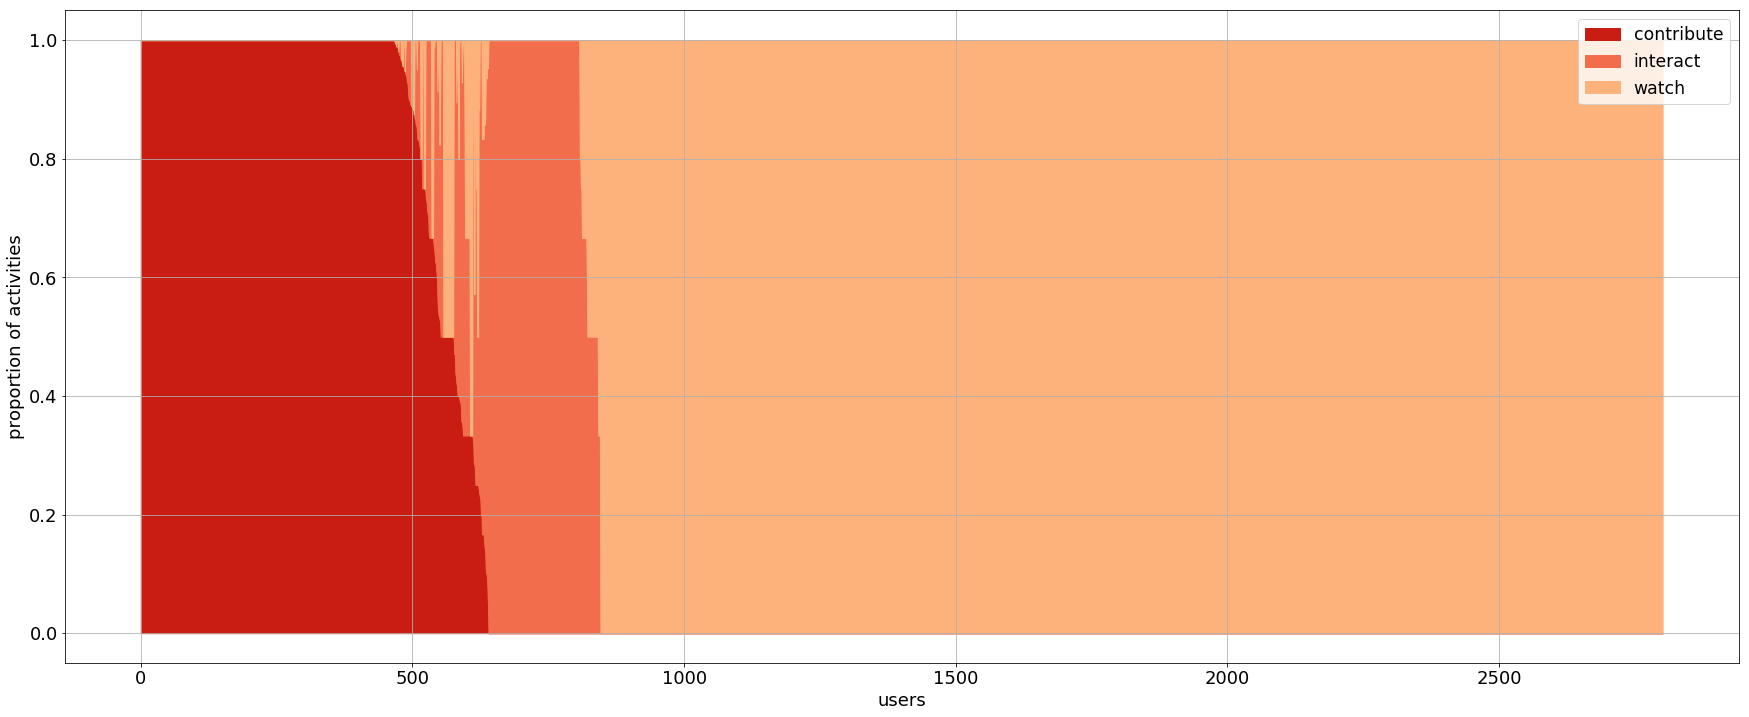

In [69]:
font = 18

plt.figure(figsize=(30, 12))

N = norm_u_distr.shape[0]
x = range(N)
y = norm_u_distr.sample(N).sort_values(by=['contribute', 'interact',], ascending=False)

plt.fill_between(x, 0, y["contribute"], label='contribute', color=colors[0])
plt.fill_between(x, y["contribute"], y["interact"]+y["contribute"], label='interact', color=colors[1])
#plt.fill_between(x, y["contribute"]+y["interact"], y["interact"]+y["contribute"]+y["fork"], label='fork', color=colors[2])
plt.fill_between(x, y["interact"] + y['contribute'], y["watch"]+y["interact"]+y['contribute'], 
                                                                                         label='watch', color=colors[2])
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('users', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

In [70]:
N_contrib = norm_u_distr[norm_u_distr['contribute'] > 0].shape[0]
print(N_contrib, float(N_contrib)/N)

640 0.22840827980014275


In [71]:
N_interact = norm_u_distr[(norm_u_distr['contribute'] == 0) & (norm_u_distr['interact'] > 0)].shape[0]
print(N_interact, float(N_interact)/N)

206 0.07351891506067094


In [30]:
N_fork = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0)].shape[0]
print(N_fork, float(N_fork)/N)

410 0.14632405424696646


In [31]:
N_fork_only = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0) &
                      (norm_u_distr['watch'] == 0)].shape[0]
print(N_fork_only, float(N_fork_only)/N)

315 0.11241970021413276


In [72]:
N_watch = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      #(norm_u_distr['fork'] == 0) &
                      (norm_u_distr['watch'] > 0)].shape[0]
print(N_watch, float(N_watch)/N)

1956 0.6980728051391863


In [33]:
N_w_f = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0) &
                      (norm_u_distr['watch'] > 0)].shape[0]
print(N_w_f, float(N_w_f)/N) 

95 0.03390435403283369


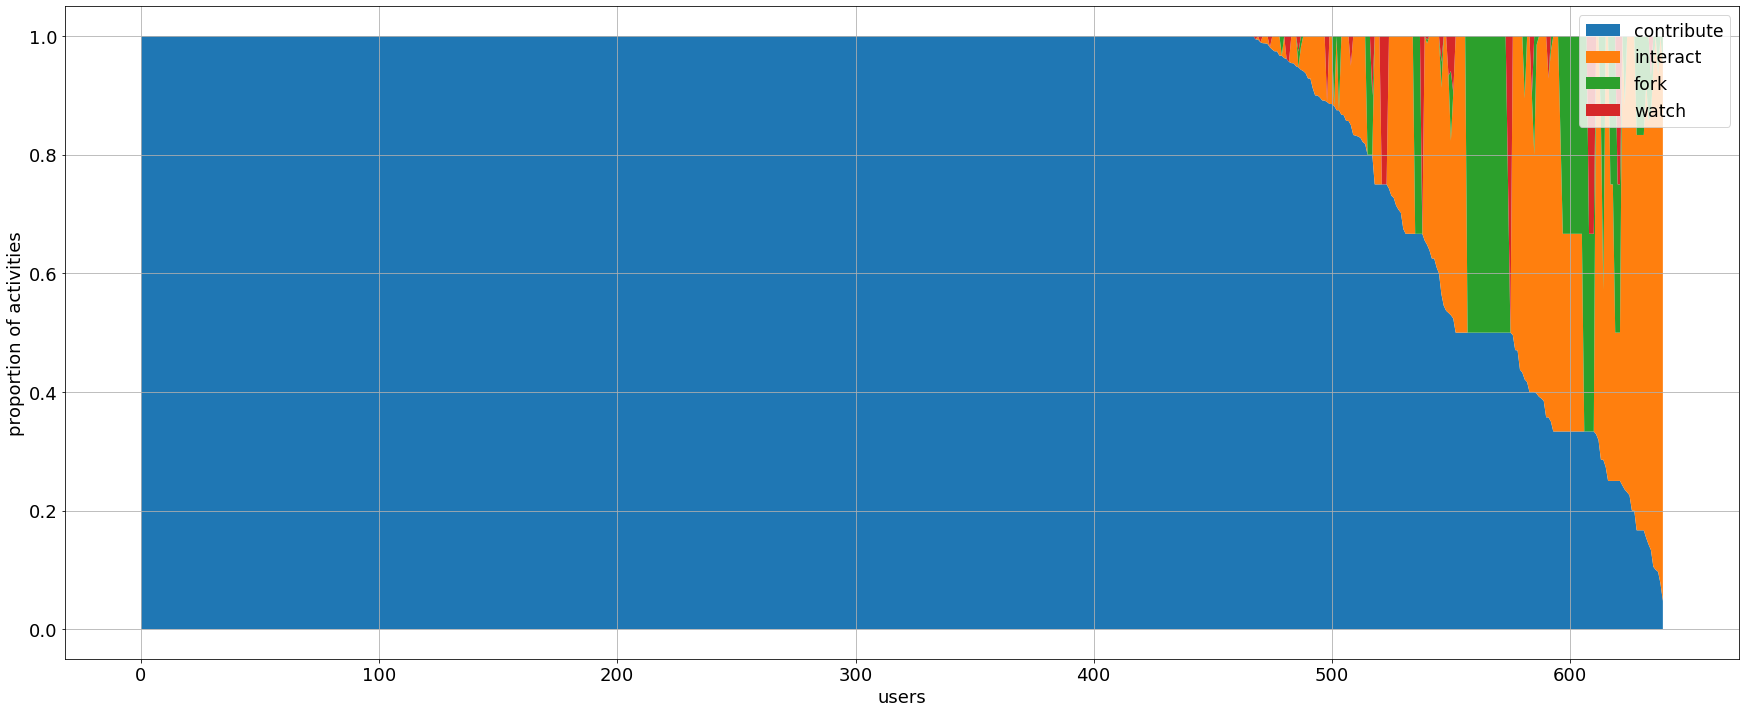

In [26]:
font = 18

plt.figure(figsize=(30, 12))


y = norm_u_distr[norm_u_distr['contribute']>0].sort_values(by=['contribute','interact','fork'], ascending=False)
x = range(y.shape[0])

plt.fill_between(x, 0, y["contribute"], label='contribute')
plt.fill_between(x, y["contribute"], y["interact"]+y["contribute"], label='interact')
plt.fill_between(x, y["contribute"]+y["interact"], y["interact"]+y["contribute"]+y["fork"], label='fork')
plt.fill_between(x, y["interact"] + y['contribute']+y["fork"], y["watch"]+y["interact"]+y['contribute']+y["fork"], 
                                                                                         label='watch')
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('users', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

## Activities distribution month by month

In [27]:
import pytz

In [28]:
start_d = datetime(2018, 1, 1, tzinfo=pytz.timezone('UTC'))
next_d = start_d + pd.DateOffset(months=1)

cat_distr = {'contribute': [], 'interact': [], 'watch': [], 'fork': []}
for _ in range(12):
    
    curr_a = a18[(a18['created_at'] >= start_d) & (a18['created_at'] < next_d)]

    cat = curr_a.groupby(by=['target', 'cat'])[['source']].count().reset_index()
    cat.columns = ['project', 'category', '#events']

    
    distr = cat.pivot(index='project', columns='category', values='#events').fillna(0)
    norm_distr = distr.apply(lambda x: get_perc_distr(x, cat_list_2), axis=1)
    for c in cat_list_2:
        cat_distr[c].append(norm_distr[c].values)
    
    start_d = next_d
    next_d = start_d + pd.DateOffset(months=1)

In [29]:
base = start_d
date_list = [base + pd.DateOffset(months=x) for x in range(0, 12)]
date_labels = [x.strftime('%b %Y') for x in date_list]

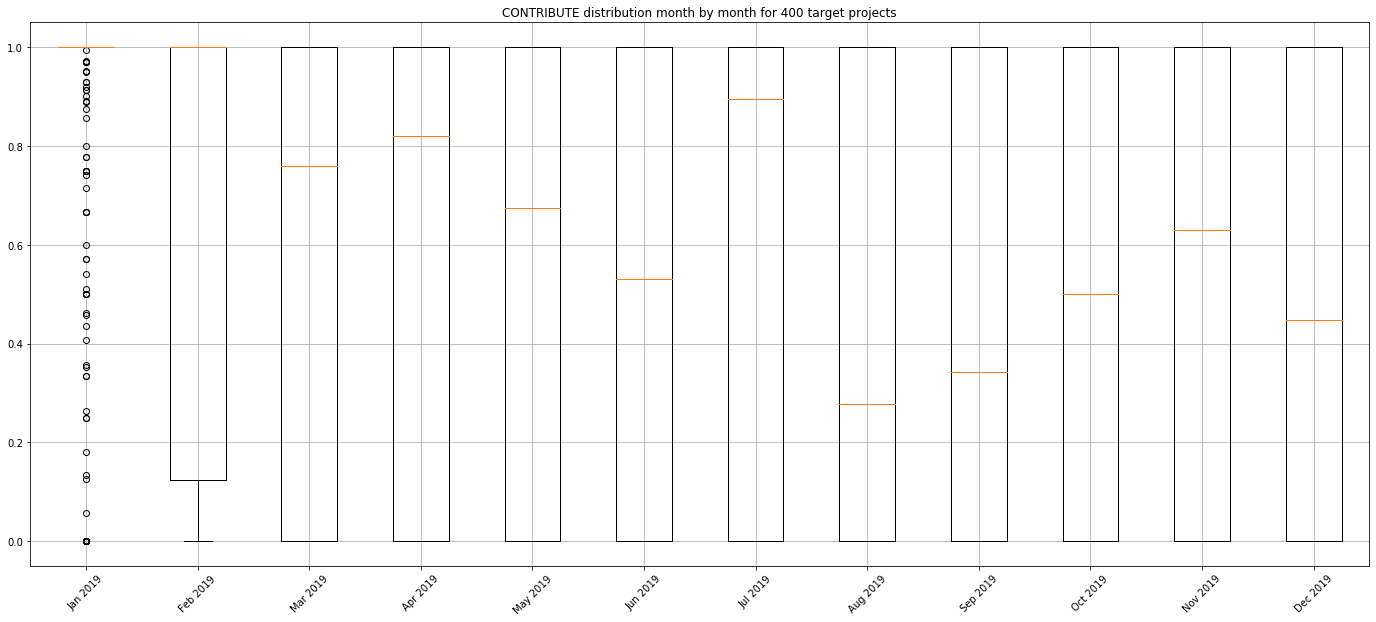

In [30]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['contribute'])
plt.xticks(range(1, 13), date_labels, rotation=45)
plt.title('CONTRIBUTE distribution month by month for 400 target projects')
plt.grid()

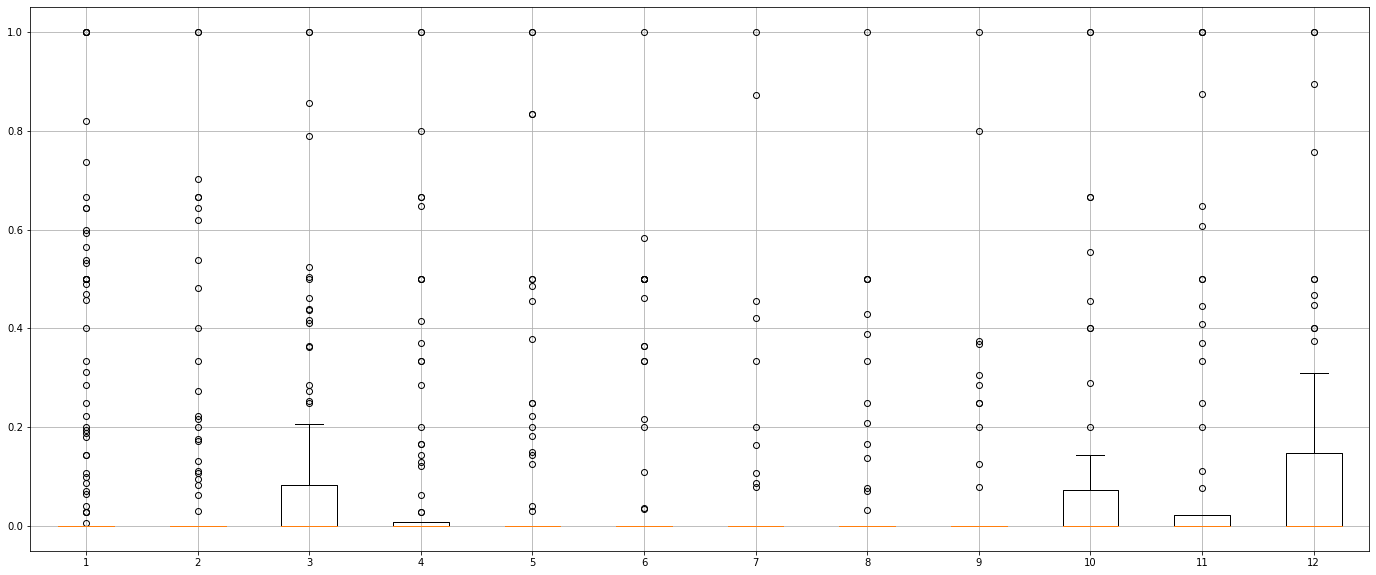

In [31]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['interact'])
plt.grid()

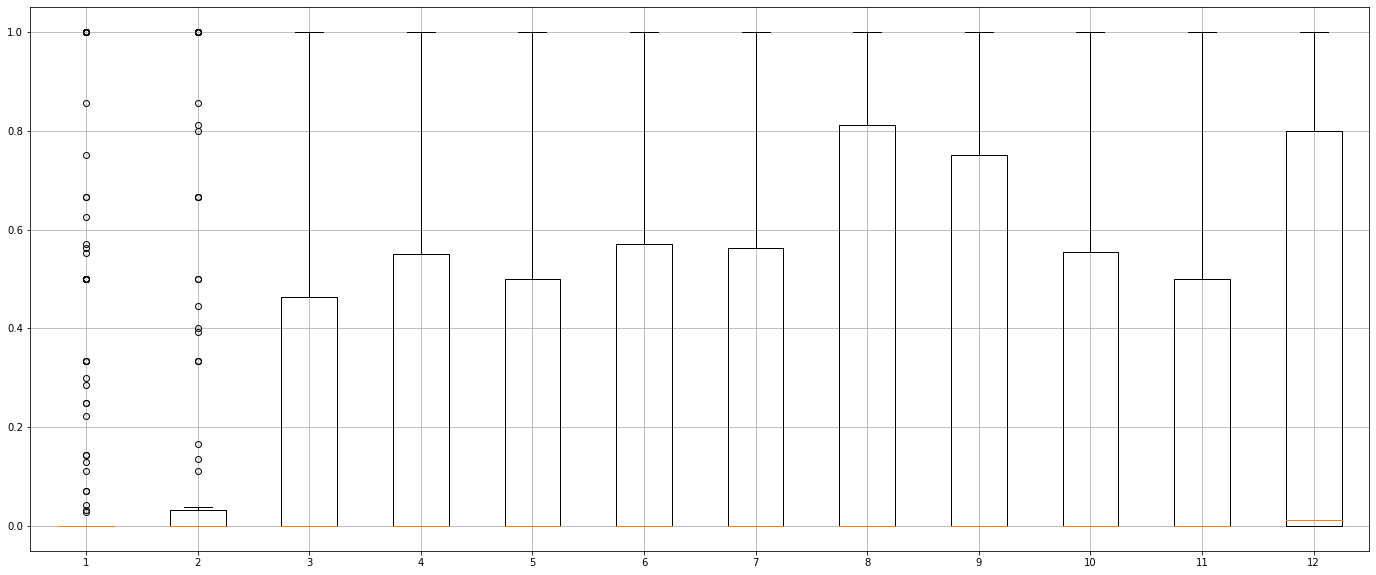

In [32]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['watch'])
plt.grid()

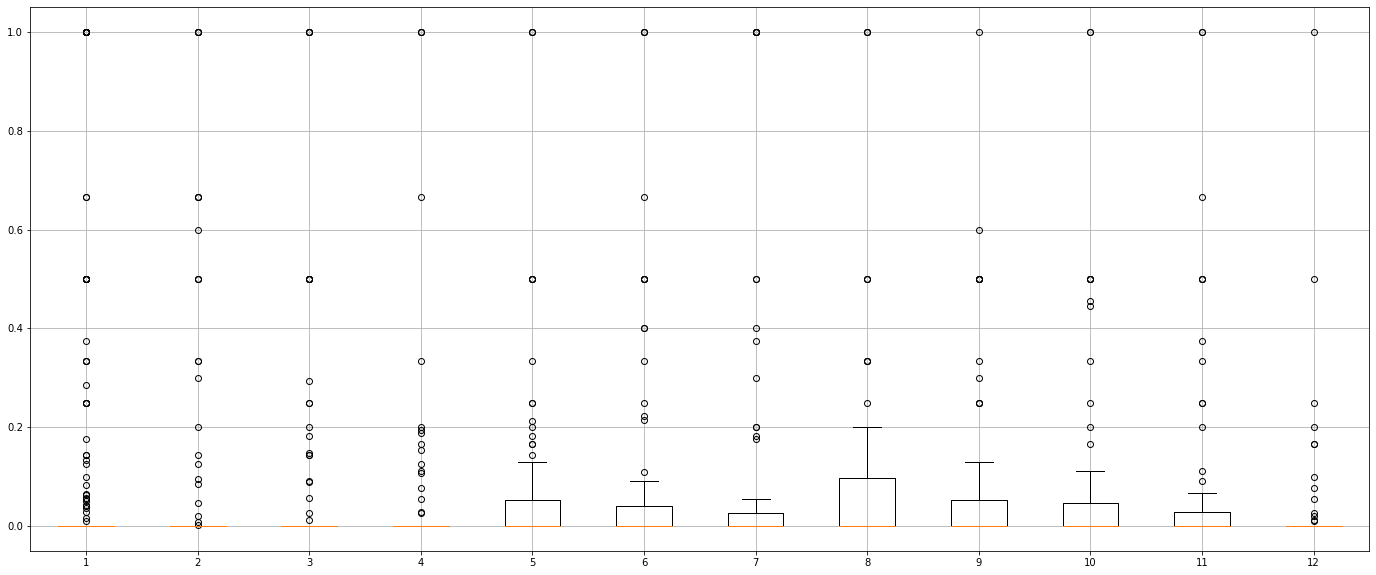

In [33]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['fork'])
plt.grid()

## Activities Distribution inside projects

In [34]:
counts = a18.groupby(by=['target', 'cat'])[['source']].count().reset_index()
counts.columns = ['project', 'category', '#events']
counts.head()

,project,category,#events
0,762119,contribute,636
1,762119,interact,88
2,762119,watch,1
3,1186540,contribute,11
4,1186540,fork,1


In [35]:
#cmap = cm.get_cmap('autumn')
#counts.pivot(index='project', columns='category', values='#events').fillna(0)\
#                                .plot(kind='bar', stacked=True, 
#                                      figsize=(20,10), title='Category distribution in 2018', cmap=cmap)

In [36]:
activity_counts = a18.groupby(by=['target', 'event'])[['source']].count().reset_index()
activity_counts.columns = ['project', 'event', 'freq']
activity_counts.head()

,project,event,freq
0,762119,CreateEvent,64
1,762119,DeleteEvent,43
2,762119,IssueCommentEvent,5
3,762119,PullRequestEvent,85
4,762119,PullRequestReviewCommentEvent,83


In [37]:
sort_events = ['CreateEvent', 'DeleteEvent', 'PullRequestEvent', 'PushEvent','ReleaseEvent', 'MemberEvent',
              'CommitCommentEvent', 'GollumEvent', 'PullRequestReviewCommentEvent','IssuesEvent', 
               'IssueCommentEvent',
                'ForkEvent', 'WatchEvent']

In [38]:
stacked_activity = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)
stacked_activity = stacked_activity[sort_events]

In [39]:
cmap = cm.get_cmap('Spectral')
#stacked_activity.plot(kind='bar', stacked=True, figsize=(20,10), title='Events distribution in 2018', cmap=cmap)

In [40]:
elist = []

for e in categories.values():
    elist  = elist + e

In [41]:
stacked_activity_norm = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)\
        .apply(lambda x: get_perc_distr(x, elist), axis=1)

# sort columns
stacked_activity_norm = stacked_activity_norm[sort_events]

/home/brambilla/anaconda3/envs/oss-p/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [42]:
# sort projects
stacked_activity_norm = stacked_activity_norm.sort_values(by=['WatchEvent'])

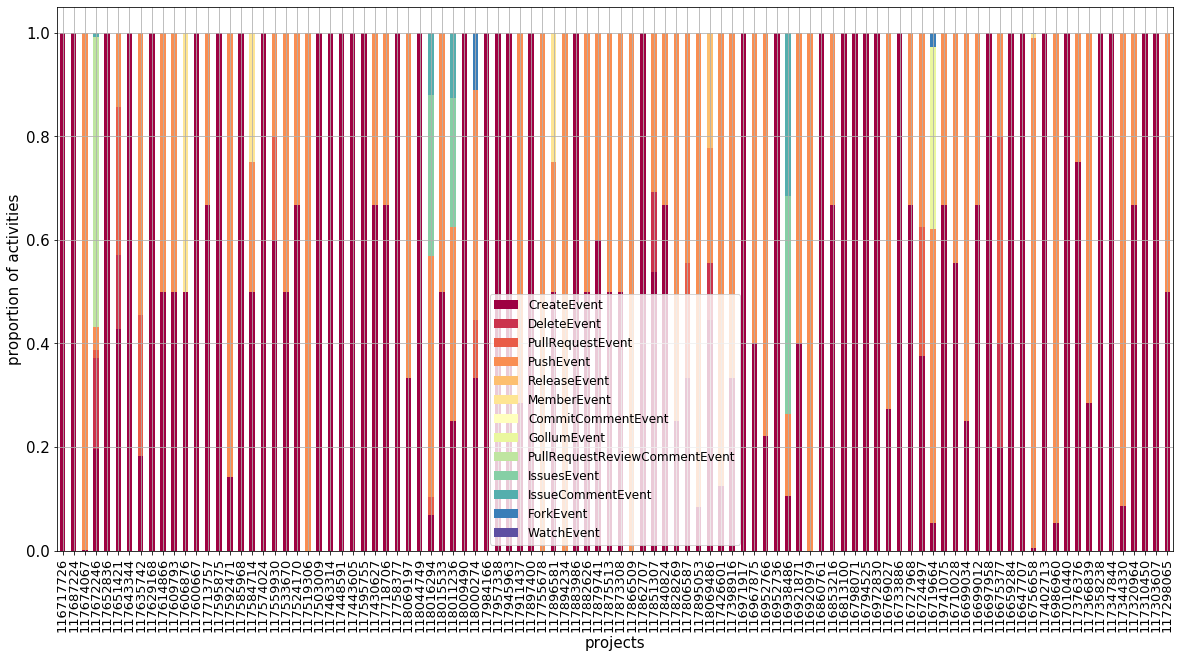

In [43]:
stacked_activity_norm.iloc[:100].plot(kind='bar', stacked=True, figsize=(20,10), cmap=cmap)

font = 15
plt.grid()
plt.legend(fontsize='large')
plt.xlabel('projects', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font-2);
plt.yticks(fontsize=font);

In [44]:
elist

['WatchEvent',
 'CommitCommentEvent',
 'GollumEvent',
 'PullRequestReviewCommentEvent',
 'IssuesEvent',
 'IssueCommentEvent',
 'CreateEvent',
 'DeleteEvent',
 'PullRequestEvent',
 'PushEvent',
 'ReleaseEvent',
 'MemberEvent',
 'ForkEvent']

In [45]:
aggregated_activity = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)\
        .drop('WatchEvent', axis=1).apply(lambda x: get_perc_distr(x, elist[1:]), axis=1)

# sort columns
aggregated_activity = aggregated_activity[sort_events[:-1]]

/home/brambilla/anaconda3/envs/oss-p/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


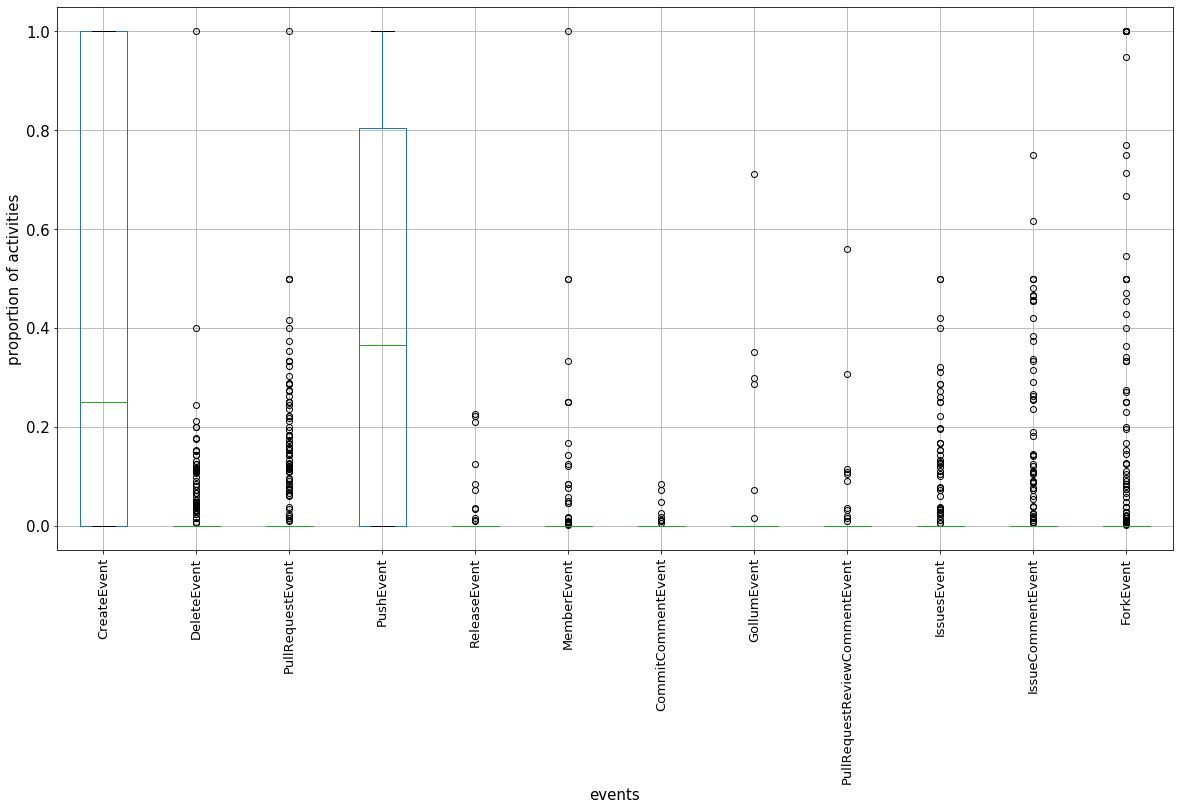

In [46]:
aggregated_activity.boxplot(figsize=(20, 10), rot=90)

font = 15
plt.xlabel('events', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font-2);
plt.yticks(fontsize=font);

## Single Project Zoom

In [53]:
p_sample = a18[a18['target'] == 762119]

In [54]:
p_sample.shape

(725, 5)

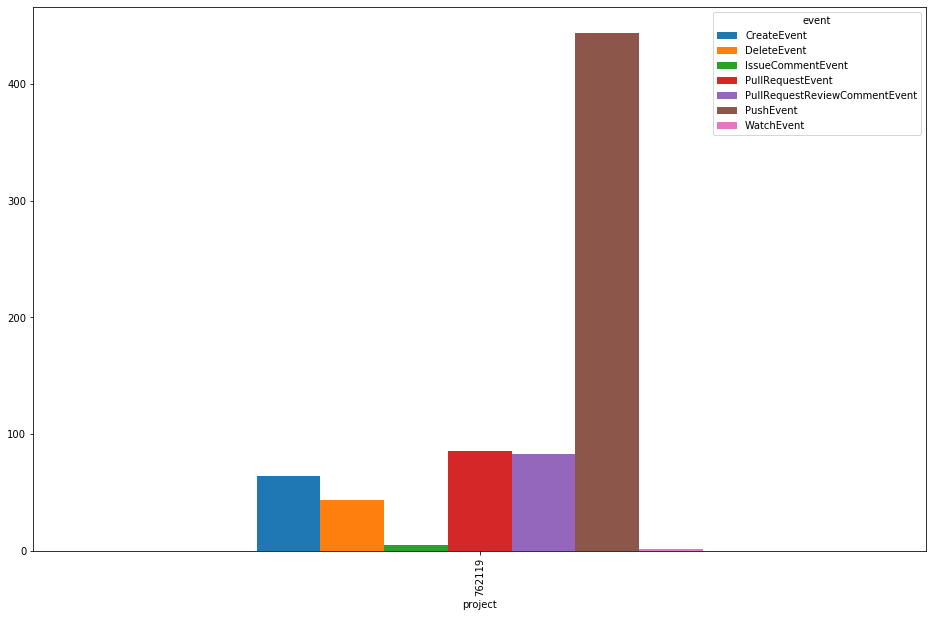

In [55]:
events = p_sample.groupby(by=['target', 'event'])[['source']].count().reset_index()
events.columns = ['project', 'event', '#events']
events.pivot(index='project', columns='event', values='#events').plot(kind='bar', figsize=(16,10))

In [56]:
start_d = datetime(2018, 1, 1, tzinfo=pytz.timezone('UTC'))
next_d = start_d + pd.DateOffset(months=1)

df = pd.DataFrame()
for _ in range(12):
    
    curr_a = p_sample[(p_sample['created_at'] >= start_d) & (p_sample['created_at'] < next_d)]

    events = curr_a.groupby(by=['target', 'event'])[['source']].count().reset_index()
    events.columns = ['project', 'event', '#events']
    row = events.pivot(index='project', columns='event', values='#events')
    row['date'] = start_d.strftime('%b %Y')
    row = row.set_index('date')
    
    df = df.append(row)
    
    start_d = next_d
    next_d = start_d + pd.DateOffset(months=1)

/home/brambilla/anaconda3/envs/oss-p/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


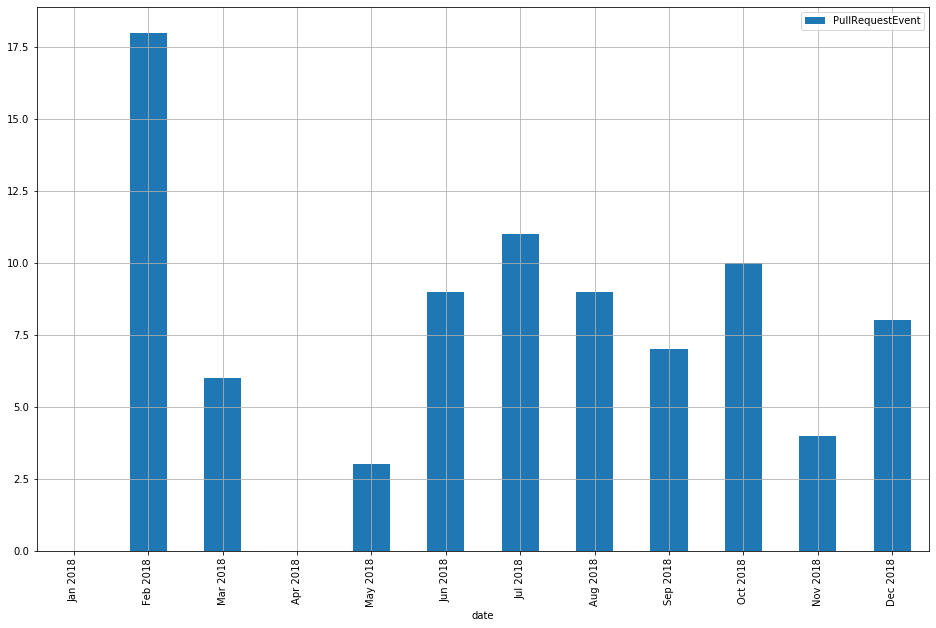

In [58]:
df[[ 'PullRequestEvent']].plot(kind='bar', figsize=(16,10), grid=True);

### Project timeseries

In [59]:
p_ts = p_sample.drop(['source'], axis=1).set_index('created_at')
releases = p_ts[p_ts['event'] == 'ReleaseEvent']

In [60]:
p_ts.head()

,target,event,cat
created_at,,,
2018-01-26 17:25:27+00:00,762119,PushEvent,contribute
2018-01-31 11:35:28+00:00,762119,PushEvent,contribute
2018-01-26 10:39:44+00:00,762119,PushEvent,contribute
2018-01-26 11:32:43+00:00,762119,PushEvent,contribute
2018-01-22 17:25:13+00:00,762119,PushEvent,contribute


In [61]:
releases.head()

,target,event,cat
created_at,,,


In [64]:
all_ts = pd.DataFrame()
for c in ['contribute', 'interact', 'watch', 'fork']:
    ts = p_ts[p_ts['cat'] == c].groupby(pd.Grouper(freq='D'))[['target']].count()
    ts.columns = [c]
    
    if ts.shape[0] > 0:
        all_ts = pd.concat([all_ts, ts], axis=1)

/home/brambilla/anaconda3/envs/oss-p/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


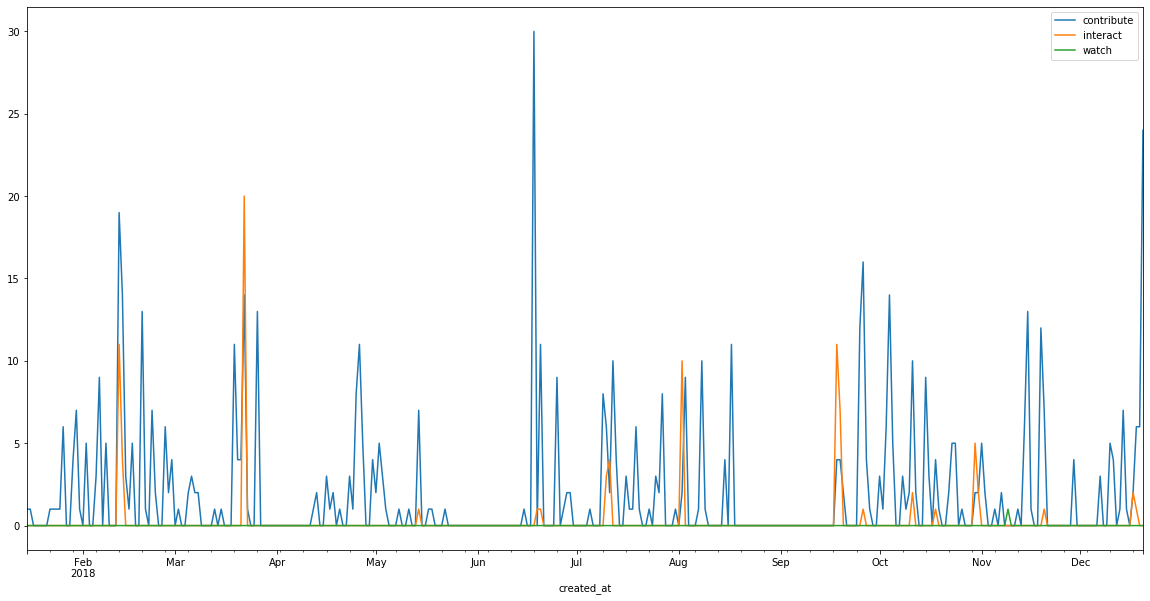

In [65]:
all_ts.fillna(0).plot(figsize=(20, 10))

for r in releases.index:
    plt.axvline(r.date(), linestyle='--', color='black', linewidth=0.5)

### Zypf's Distribution

Sample projects

In [66]:
ranking = p_sample.groupby('source')['event'].count().sort_values(ascending=False).reset_index(drop=True)

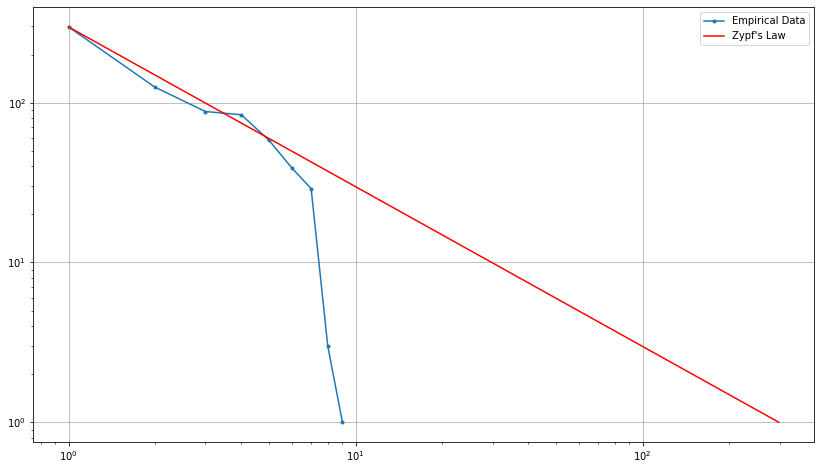

In [67]:
plt.figure(figsize=(14, 8))
x_axis = range(1, len(ranking)+1)
plt.loglog(x_axis, ranking.values, marker=".", label='Empirical Data')
plt.plot([1, ranking.values[0]],[ranking.values[0] ,1], color='r', label='Zypf\'s Law')
plt.grid()
plt.legend()

In [68]:
len(ranking)

9

In [69]:
test_p = a18['target'].unique()

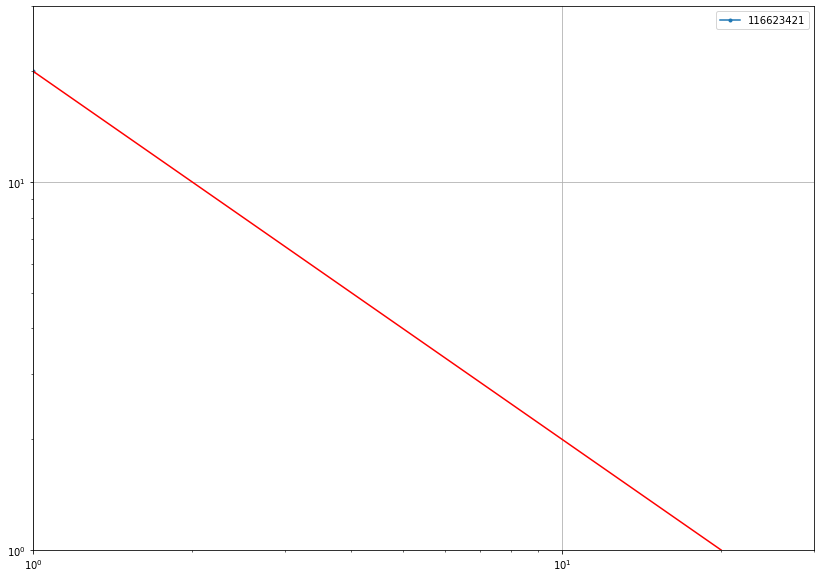

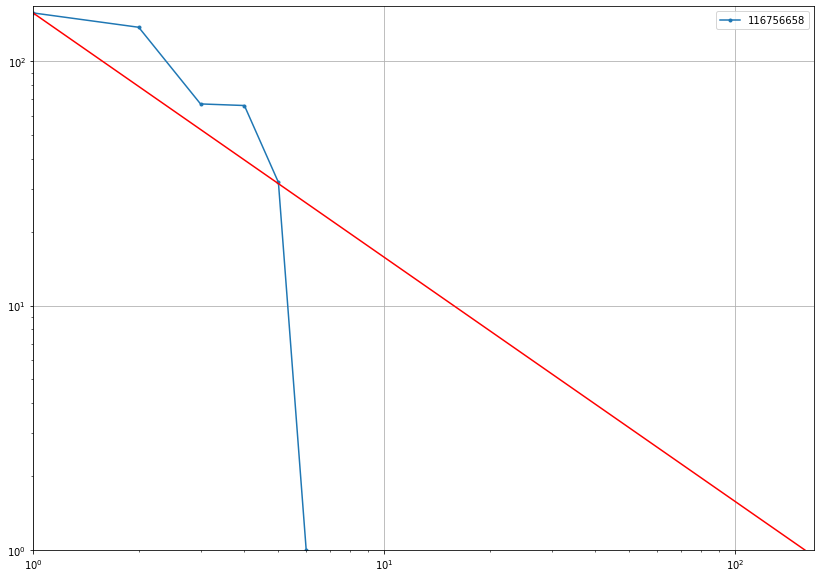

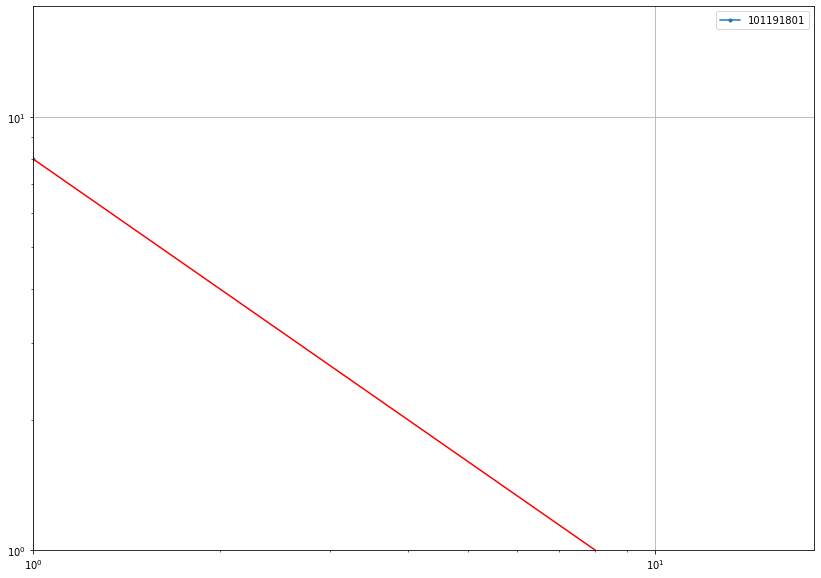

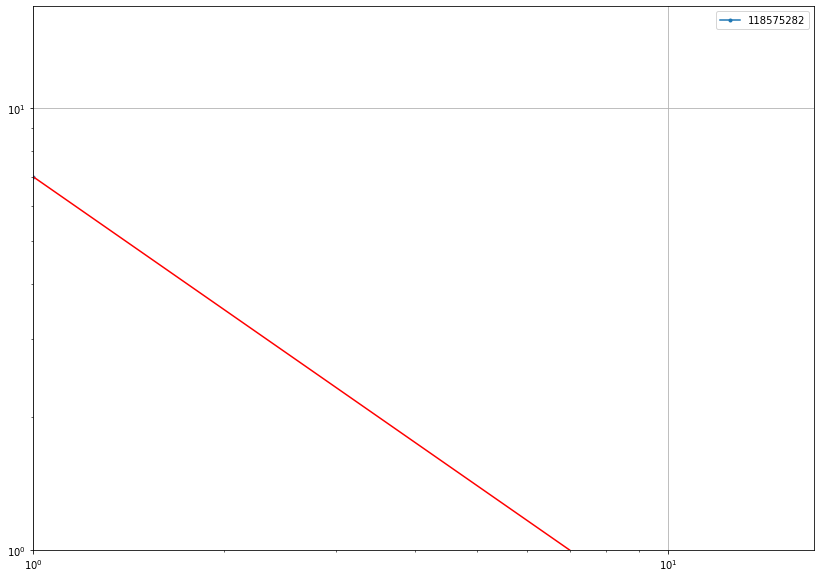

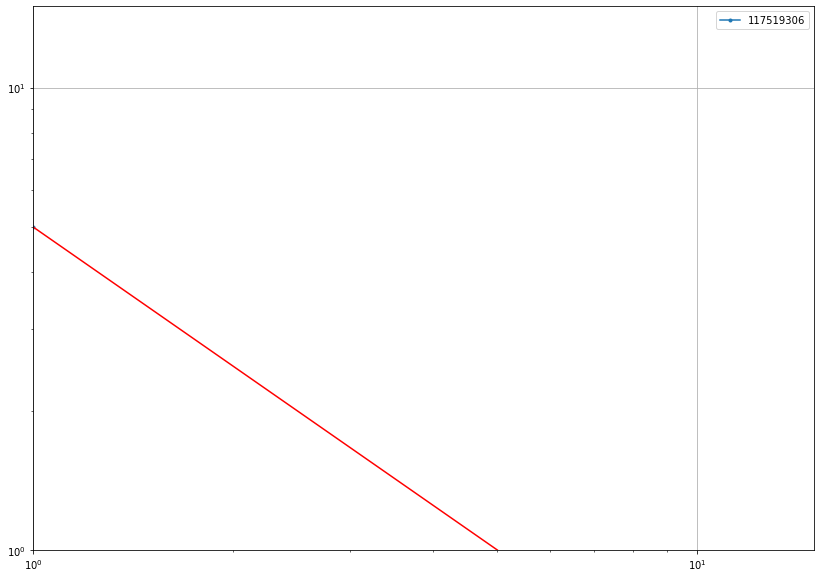

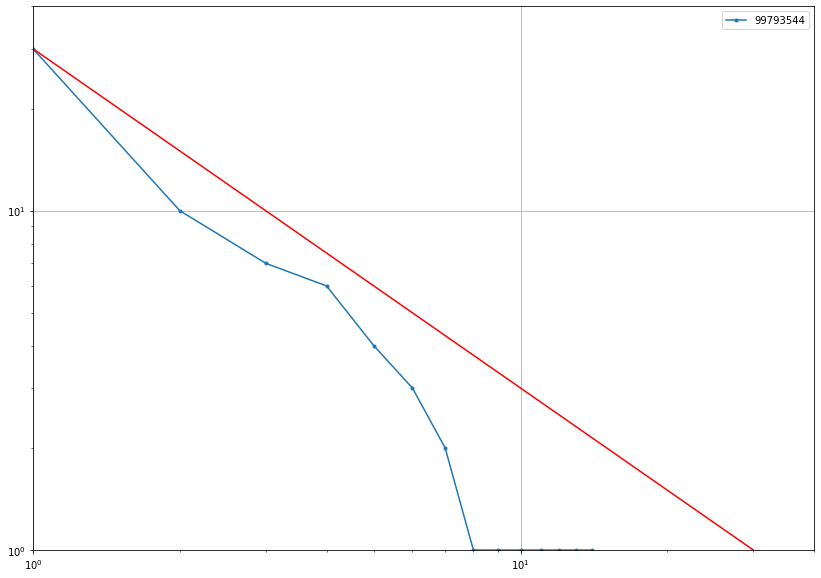

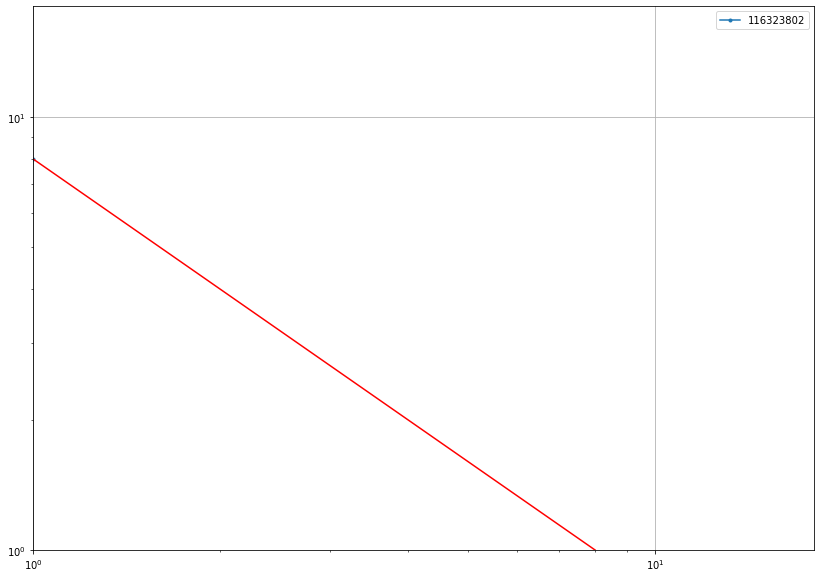

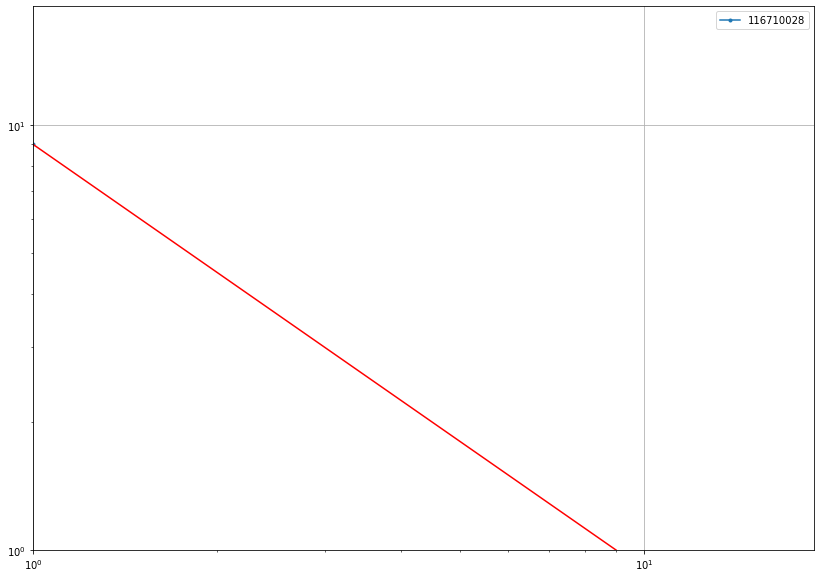

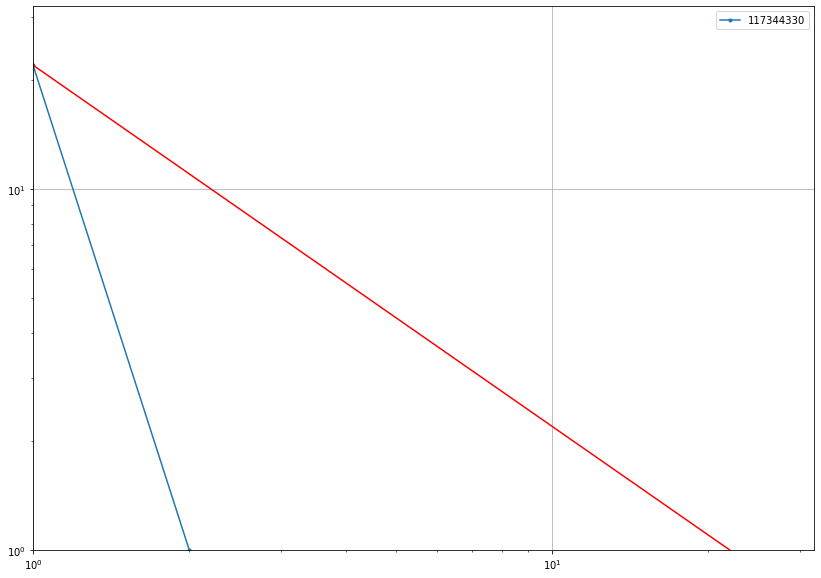

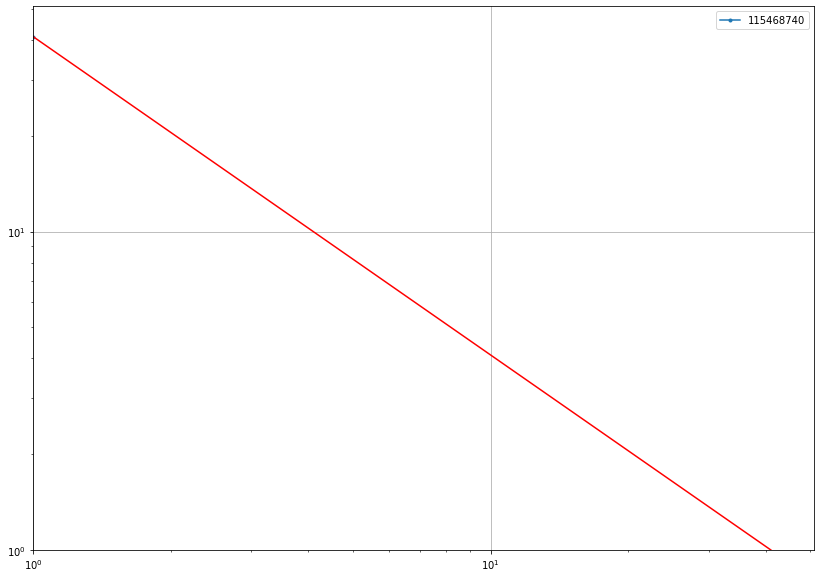

In [70]:
n = 10
for p in test_p[:n]:
    p_sample = a18[a18['target'] == p]
    uranking = p_sample.groupby('source')['event'].count().sort_values(ascending=False).reset_index(drop=True)
    plt.figure(figsize=(14, 10))
    
    x_axis = range(1, len(uranking)+1)
    plt.loglog(x_axis, uranking.values, marker=".", label=str(p))
    plt.plot([1, uranking.values[0]],[uranking.values[0] ,1], color='r')
    plt.xlim([1, max(max(uranking.values), len(uranking))+10])
    plt.ylim([1, max(uranking.values)+10])
    plt.grid()
    plt.legend()